In [1]:
from math import ceil
from spatial_scan import scan
from vae import VAE, encoder, decoder, tf, keras,l

batch_len = 1000
lmax=0.1

with open("../mc-sampling/good-runs/test_30_5_0.05_0.3_0.1_10000_1000_1000_x.txt") as f:
    data = [[float(i.strip()) for i in s.split(" ") if i!=""] for s in f.read().split("\n") if s!=""]
    xyz=[[[data[h][i+3*j]for i in range(3)]for j in range(len(data[h])//3)]for h in range(len(data))]
    del data

# print(len(data), [len(data[i]) for i in range(len(data))])
model_checkpoint_callback = keras.callbacks.ModelCheckpoint("./checkpoints/", save_best_only=True)

def change_l(e,log):
    global l, lmax
    print(l)
    l=(1-1/(1+e))*lmax

regularization_callback = keras.callbacks.LambdaCallback(on_epoch_end=change_l)
    
if False:#len(argv)>2 and argv[2]=="--resume":
    vae=keras.models.load_model("./model_info/")
else:
    vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

2023-05-16 15:07:19.180752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:07:19.959559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-16 15:07:19.959638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-16 15:07:19.959646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
for i in range(1):#(ceil(len(xyz)/batch_len)):
    bdata = [] # will hold bucketed data version
    for j in range(batch_len*i, batch_len*(i+1)):
        if j>len(xyz):
            break
        #print(xyz[j])
        bdata.append([scan(xyz[j],5,5,5)])
    dataset = tf.data.Dataset.from_tensor_slices((bdata,))
    vae.fit(dataset, epochs=10, batch_size=128, callbacks=[model_checkpoint_callback, regularization_callback])

2023-05-16 15:07:23.329067: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.
2023-05-16 15:07:39.752733: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.


Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 2.4068e-04 - reconstruction_loss: 2.4011e-04 - kl_loss: 7.3738e-04WARNING:tensorflow:Can save best model only with val_loss available, skipping.
0
1000/1000 [==============================] - 124s 121ms/step - loss: 2.4068e-04 - reconstruction_loss: 2.4011e-04 - kl_loss: 7.3738e-04
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 2.4000e-04 - reconstruction_loss: 2.4000e-04 - kl_loss: 5.2650e-04WARNING:tensorflow:Can save best model only with val_loss available, skipping.
0.0
1000/1000 [==============================] - 122s 122ms/step - loss: 2.4000e-04 - reconstruction_loss: 2.4000e-04 - kl_loss: 5.2650e-04
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 2.4000e-04 - reconstruction_loss: 2.4000e-04 - kl_loss: 4.8064e-04WARNING:tensorflow:Can save best model only with val_loss available, skipping.
0.05
1000/1000 [==============================] - 123s 123ms/step - los

In [3]:
try:
    vae.load_weights("./checkpoints/")
except Exception as e:
    print(e)
finally:
    keras.models.save_model(vae.encoder, "./model-info/enc/")
    keras.models.save_model(vae.decoder, "./model-info/dec/")
    

Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.


2023-05-16 15:28:22.652576: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./checkpoints/: FAILED_PRECONDITION: checkpoints; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


INFO:tensorflow:Assets written to: ./model-info/enc/assets


INFO:tensorflow:Assets written to: ./model-info/enc/assets


INFO:tensorflow:Assets written to: ./model-info/dec/assets


INFO:tensorflow:Assets written to: ./model-info/dec/assets


In [6]:
vae.history.history

{'loss': [0.00024011434288695455,
  0.00023999942641239613,
  0.00023999888799153268,
  0.00023999888799153268,
  0.000239998844335787,
  0.000239998844335787,
  0.00023999882978387177,
  0.00023999882978387177,
  0.00023999887343961746,
  0.00023999882978387177],
 'reconstruction_loss': [0.00024011434288695455,
  0.00023999942641239613,
  0.00023999888799153268,
  0.00023999888799153268,
  0.000239998844335787,
  0.000239998844335787,
  0.00023999882978387177,
  0.00023999882978387177,
  0.00023999887343961746,
  0.00023999882978387177],
 'kl_loss': [0.0007373806438408792,
  0.0005265012732706964,
  0.0004806423094123602,
  0.00045603036414831877,
  0.000452005973784253,
  0.00044772520777769387,
  0.0004452751891221851,
  0.00044296434498392045,
  0.0004105816478841007,
  0.00038737882277928293]}

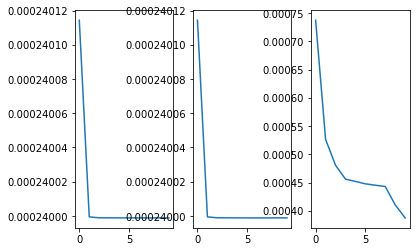

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=3)
ax[0].plot(vae.history.history["loss"])
ax[1].plot(vae.history.history["reconstruction_loss"])
ax[2].plot(vae.history.history["kl_loss"])

In [10]:
test_set=[]
for j in range(batch_len, batch_len*2):
    if j>len(xyz):
        break
    test_set.append([scan(xyz[j],5,5,5)])

dataset = tf.data.Dataset.from_tensor_slices((bdata,))

pred = vae.encoder.predict(dataset)

2023-05-16 15:41:45.423447: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.
2023-05-16 15:41:55.696091: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.


1000/1000 [==============================] - 17s 16ms/step


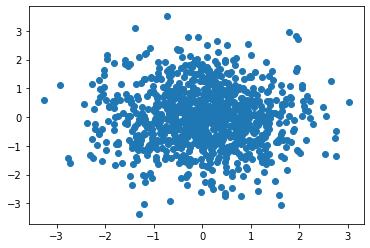

In [16]:
plt.scatter([p[0] for p in pred[2]], [p[1] for p in pred[2]])